# Dynamical regional trends of Eddy Kinetic Energy and Sea surface temperature gradients ($\left|\nabla \mathrm{SST} \right|$)

This Jupyter notebook reproduces Figure 5 of the manuscript "Global changes in oceanic mesoscale currents over the satellite altimetry record".

In [1]:
# Import libraries
import xarray as xr
import cmocean as cm
import cartopy.crs as ccrs

import pylab as plt
import numpy as np
import pandas as pd
from scipy import stats
# Inline plotting
%matplotlib inline

In [2]:
# Import plot utilities
from plot_utils import (truncate_colormap, ccrs_land, add_patches, 
                        area, plot_dynamical_regions, significance_mk, plot_bars,
                        compute_trends)

In [3]:
# Load ocean basin masks
ocean_basins = xr.open_dataset('../datasets/ocean_basins_and_dynamical_masks.nc')

In [4]:
print(ocean_basins) # This dataset includes all the mask used in the study in a 1°x 1° grid

<xarray.Dataset>
Dimensions:                          (lat: 180, lon: 360)
Coordinates:
  * lon                              (lon) float32 0.5 1.5 2.5 ... 358.5 359.5
  * lat                              (lat) float32 -89.5 -88.5 ... 88.5 89.5
Data variables:
    indian_ocean_mask                (lat, lon) float64 ...
    pacific_ocean_mask               (lat, lon) float64 ...
    atlantic_ocean_mask              (lat, lon) float64 ...
    southern_ocean_mask              (lat, lon) float64 ...
    remaining_processes_mask         (lat, lon) float32 ...
    boundarycurrents_processes_mask  (lat, lon) float32 ...
    gyres_processes_mask             (lat, lon) float32 ...
    equator_processes_mask           (lat, lon) float32 ...
    acc_processes_mask               (lat, lon) float32 ...
Attributes:
    title:         Ocean geographical basins and ocean dynamical processes masks
    Description:   Geographical regions consist on the following ocean basins...
    Publication:   Dataset

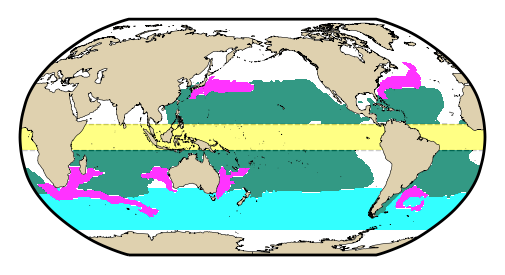

In [5]:
# Plot basin masks
fig = plt.figure(figsize=(3,3), dpi=200)
ax1 = fig.add_subplot(1, 1, 1, projection = ccrs.Robinson(central_longitude=180))
# Display basins:
plot_dynamical_regions(ax1,ocean_basins);

### Import EKE timeseries

In [6]:
dataset_EKE = xr.open_dataset('../datasets/EKE_timeseries.nc')

In [7]:
rho=1025
#Compute grid area for area-weigthed EKE
area = area(dataset_EKE.lat, dataset_EKE.lon)

In [8]:
# Compute area-weigthed EKE
EKE_area_weighted = (rho*dataset_EKE*area) # Units J m^{-1}

In [9]:
# Global EKE time-series
EKE_timeseries=EKE_area_weighted.where(abs(dataset_EKE.lat)<65)

Slice data between 65°S - 65°N and create dataset without the equator (9°S - 9°N).

In [10]:
# Global dataset 
global_EKE = EKE_timeseries.EKE # Units PJ m^{-1}

In [11]:
# Dynamical masked datasets
remaining_EKE = (global_EKE).where(ocean_basins.remaining_processes_mask==True) # Units J m^{-1}
boundary_EKE  = (global_EKE).where(ocean_basins.boundarycurrents_processes_mask==True) # Units J m^{-1}
gyres_EKE     = (global_EKE).where(ocean_basins.gyres_processes_mask==True) # Units J m^{-1}
equator_EKE   = (global_EKE).where(ocean_basins.equator_processes_mask==True) # Units J m^{-1}
acc_EKE       = (global_EKE).where(ocean_basins.acc_processes_mask==True) # Units J m^{-1}

Integrate over region (Global, Southern Ocean, Indian Ocean, Pacific Ocean, and Atlantic Ocean) and convert units from $J m^{-1}$ to $PJ m^{-1}$ (i.e. PetaJoules = $\times10^{15}$)

In [12]:
remaining_EKE = remaining_EKE.sum(('lon','lat'))/1e15 # Units PJ m^{-1}
boundary_EKE  = boundary_EKE.sum(('lon','lat'))/1e15 # Units PJ m^{-1}
gyres_EKE     = gyres_EKE.sum(('lon','lat'))/1e15 # Units PJ m^{-1}
equator_EKE   = equator_EKE.sum(('lon','lat'))/1e15 # Units PJ m^{-1}
acc_EKE       = acc_EKE.sum(('lon','lat'))/1e15 # Units PJ m^{-1}

Drop zeros at the beginning and end of record due to pre-processing (i.e. 12 month rolling average)

In [13]:
remaining_EKE = remaining_EKE.where(remaining_EKE!=0).dropna('time')
boundary_EKE  = boundary_EKE.where(boundary_EKE!=0).dropna('time')
gyres_EKE     = gyres_EKE.where(gyres_EKE!=0).dropna('time')
equator_EKE   = equator_EKE.where(equator_EKE!=0).dropna('time')
acc_EKE       = acc_EKE.where(acc_EKE!=0).dropna('time')

In [14]:
acc_EKE

<xarray.DataArray 'EKE' (time: 9265)>
array([0.6651116 , 0.66465956, 0.6642127 , ..., 0.7570659 , 0.75714433,
       0.757217  ], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 1993-07-02 1993-07-03 ... 2018-11-12

### Import mesoscale SST gradients

In [15]:
dataset_SST_grad = xr.open_dataset('../datasets/SST_grads_timeseries.nc') # Units °C m ^{-1}

Compute area-weigthed SST gradients ($\left|\nabla \mathrm{SST} \right|$)

In [16]:
mesoscale_SST_grad_area_weighted = (dataset_SST_grad.SST_grad_small_scale)*area # Units °C m

Slice data between 65°S - 65°N.

In [17]:
# Global mesoscale SST gradient time-series
mes_SST_grad_timeseries=mesoscale_SST_grad_area_weighted.where(abs(dataset_SST_grad.lat)<65)

In [18]:
global_m_SST_grad = mes_SST_grad_timeseries # Units °C m

In [19]:
remaining_m_SST_grad = (global_m_SST_grad).where(ocean_basins.remaining_processes_mask==True) # Units °C m
boundary_m_SST_grad  = (global_m_SST_grad).where(ocean_basins.boundarycurrents_processes_mask==True) # Units °C m
gyres_m_SST_grad     = (global_m_SST_grad).where(ocean_basins.gyres_processes_mask==True) # Units °C m
equator_m_SST_grad   = (global_m_SST_grad).where(ocean_basins.equator_processes_mask==True) # Units °C m
acc_m_SST_grad       = (global_m_SST_grad).where(ocean_basins.acc_processes_mask==True) # Units °C m

Integrate over region (Global, Southern Ocean, Indian Ocean, Pacific Ocean, and Atlantic Ocean) with units of $^\circ C\ m$. 

In [20]:
remaining_m_SST_grad = remaining_m_SST_grad.sum(('lon','lat'))/1e8 # Units °C m
boundary_m_SST_grad  = boundary_m_SST_grad.sum(('lon','lat'))/1e8 # Units °C m
gyres_m_SST_grad     = gyres_m_SST_grad.sum(('lon','lat'))/1e8 # Units °C m
equator_m_SST_grad   = equator_m_SST_grad.sum(('lon','lat'))/1e8 # Units °C m
acc_m_SST_grad       = acc_m_SST_grad.sum(('lon','lat'))/1e8 # Units °C m

Drop zeros at the beginning and end of record due to pre-processing (i.e. 12 month rolling average)

In [21]:
remaining_m_SST_grad = remaining_m_SST_grad.where(remaining_m_SST_grad!=0).dropna('time')
boundary_m_SST_grad  = boundary_m_SST_grad.where(boundary_m_SST_grad!=0).dropna('time')
gyres_m_SST_grad     = gyres_m_SST_grad.where(gyres_m_SST_grad!=0).dropna('time')
equator_m_SST_grad   = equator_m_SST_grad.where(equator_m_SST_grad!=0).dropna('time')
acc_m_SST_grad       = acc_m_SST_grad.where(acc_m_SST_grad!=0).dropna('time')

In [22]:
print(remaining_m_SST_grad)

<xarray.DataArray (time: 9497)>
array([2.9495409, 2.949828 , 2.9498222, ..., 3.1720533, 3.1721356,
       3.1723814], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 1993-01-01T12:00:00 ... 2019-01-01T12:00:00


#### Compute slopes and intercepts:

In [23]:
slope_SST_grad_remaining, intercept_SST_grad_remaining = compute_trends(remaining_m_SST_grad)
slope_SST_grad_boundary, intercept_SST_grad_boundary   = compute_trends(boundary_m_SST_grad)
slope_SST_grad_gyres, intercept_SST_grad_gyres         = compute_trends(gyres_m_SST_grad)
slope_SST_grad_equator, intercept_SST_grad_equator     = compute_trends(equator_m_SST_grad)
slope_SST_grad_acc, intercept_SST_grad_acc             = compute_trends(acc_m_SST_grad)

In [24]:
slope_EKE_remaining, intercept_EKE_remaining = compute_trends(remaining_EKE)
slope_EKE_boundary, intercept_EKE_boundary   = compute_trends(boundary_EKE)
slope_EKE_gyres, intercept_EKE_gyres         = compute_trends(gyres_EKE)
slope_EKE_equator, intercept_EKE_equator     = compute_trends(equator_EKE)
slope_EKE_acc, intercept_EKE_acc             = compute_trends(acc_EKE)

## Plot Figure 5 of manuscript

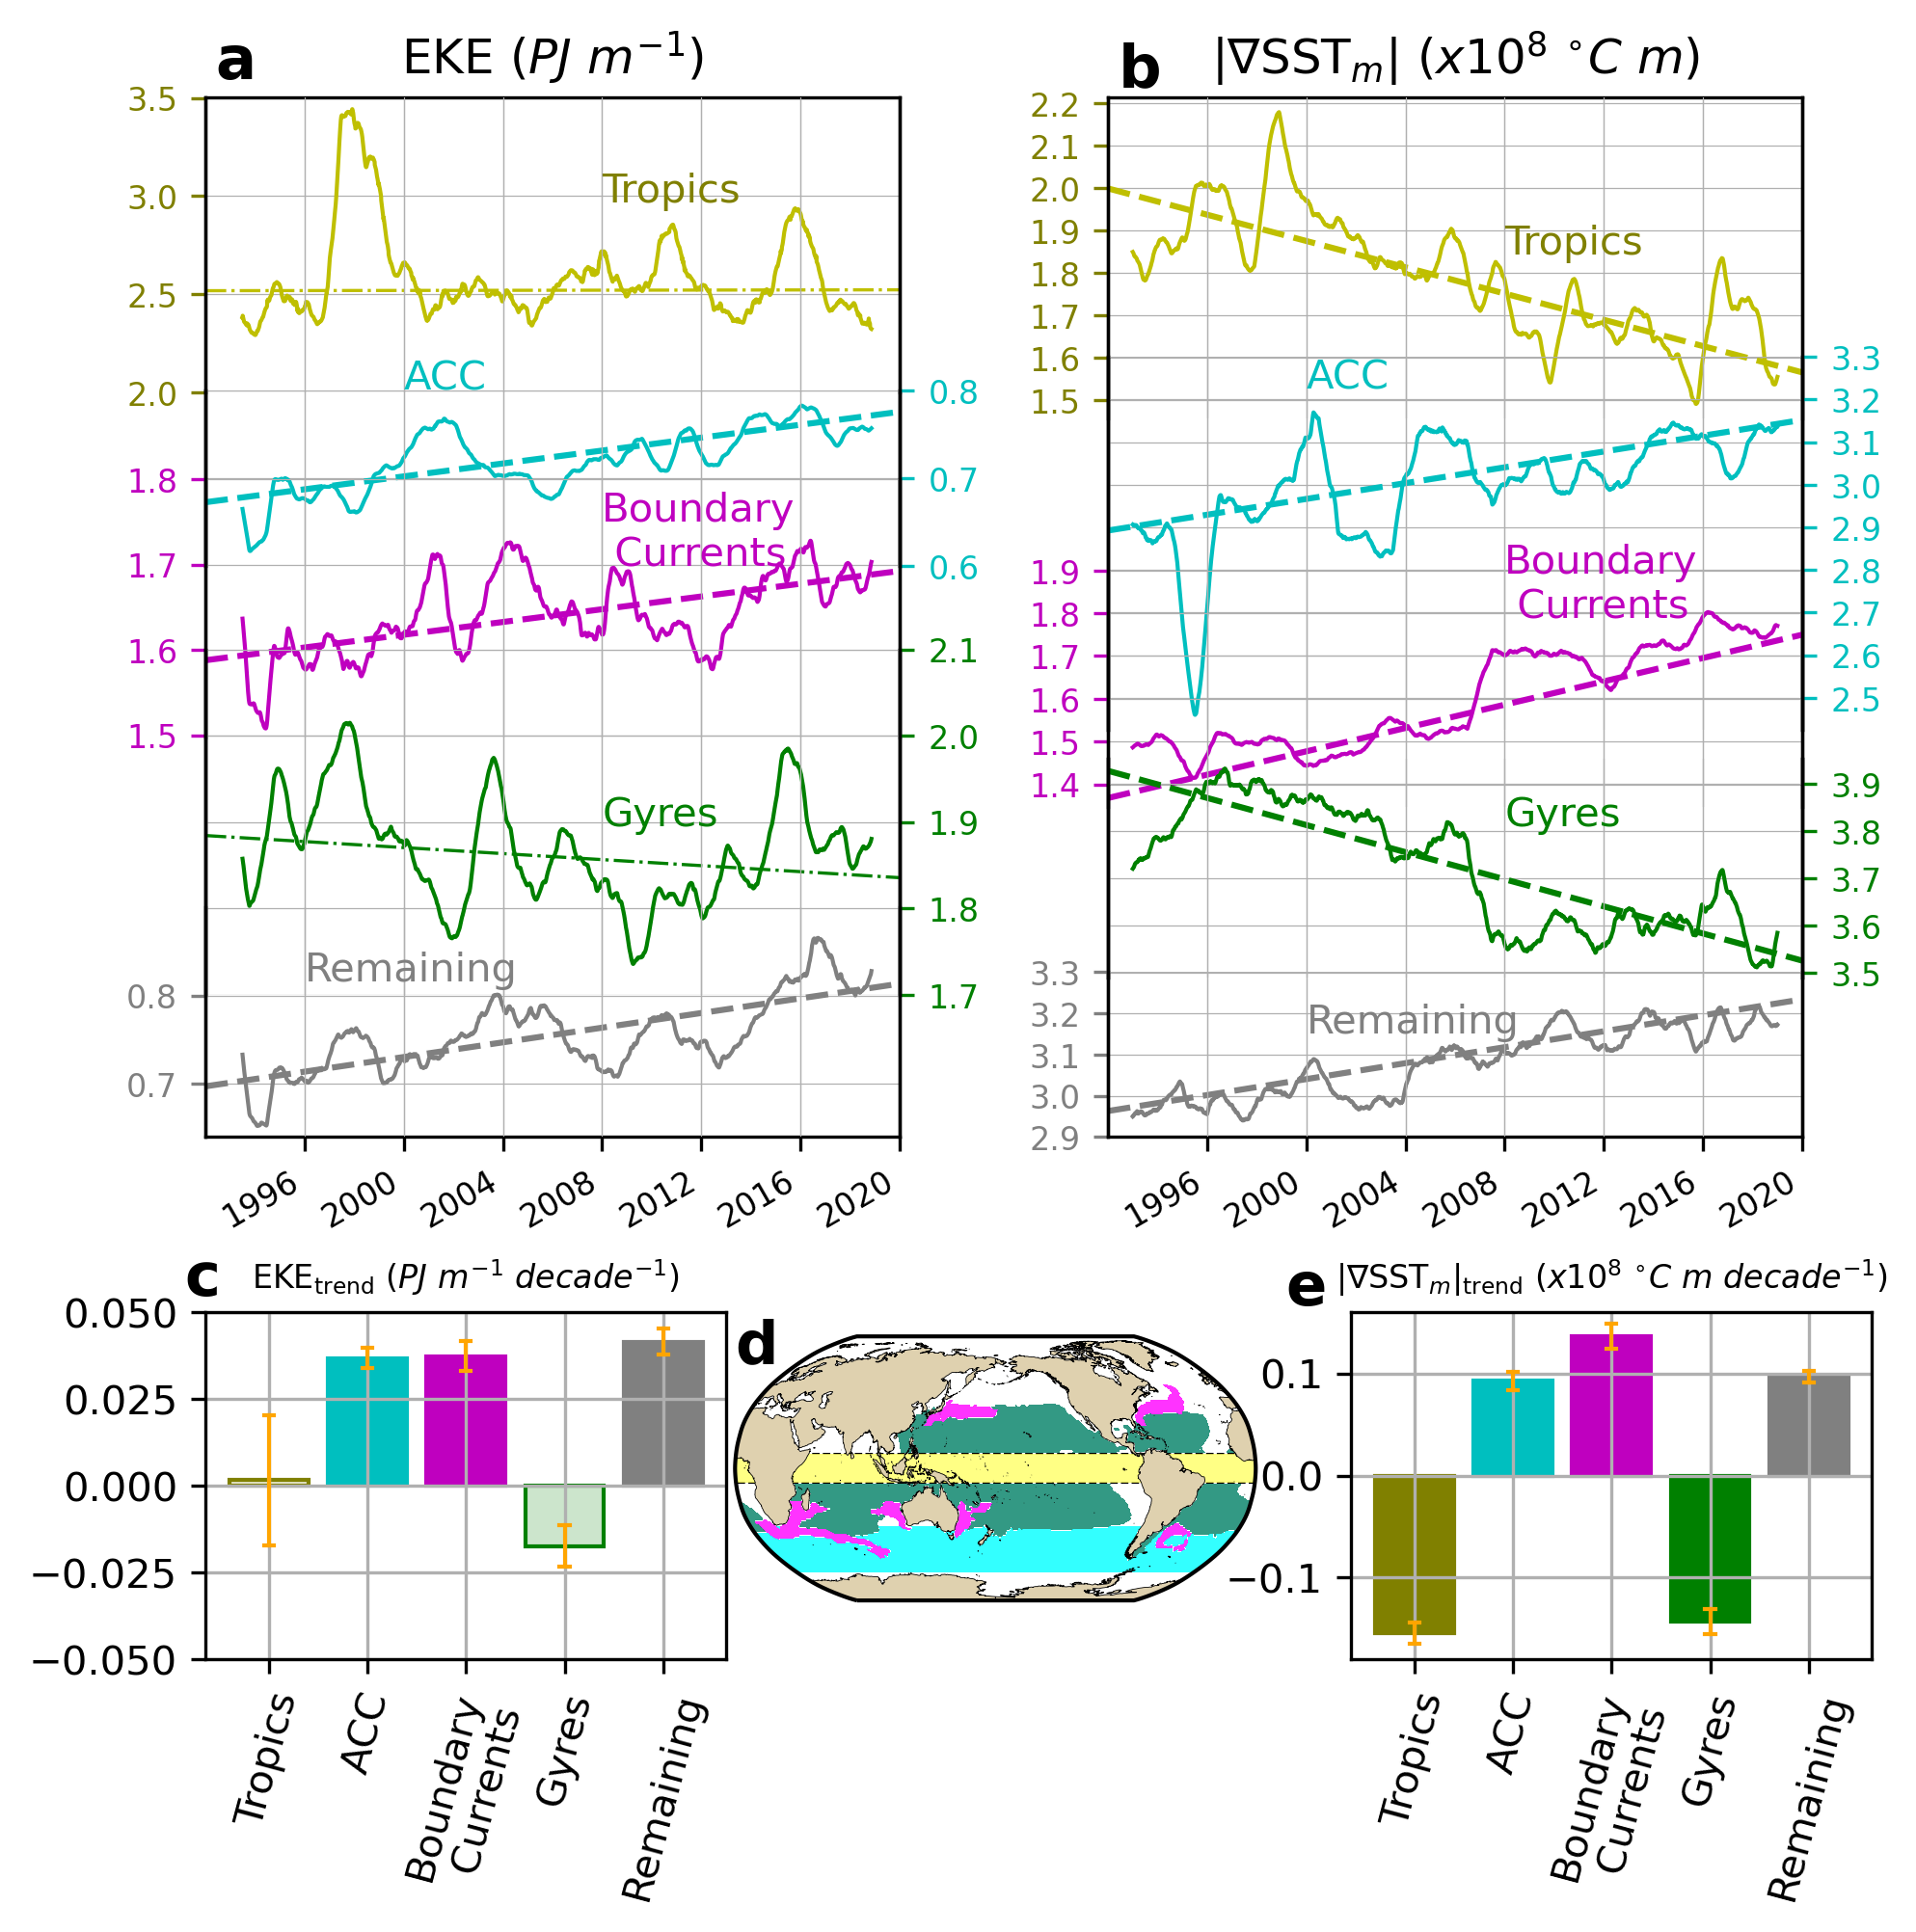

In [25]:
fig = plt.figure(figsize=(6, 6),dpi=300)

l_ax1 = fig.add_axes([0.6, 0.815, 0.4, 0.185])
l_ax2 = fig.add_axes([0.6, 0.6355, 0.4, 0.215])
l_ax2t = l_ax2.twinx()
l_ax3 = fig.add_axes([0.6, 0.591, 0.4, 0.1364])
l_ax4 = fig.add_axes([0.6, 0.493, 0.4, 0.126])
l_ax4t = l_ax4.twinx()
l_ax5 = fig.add_axes([0.6, 0.401, 0.4, 0.095])

l_ax_big = fig.add_axes([0.6, 0.401, 0.4, 0.815+0.185-0.401])

r_ax1 = fig.add_axes([0.08, 0.83, 0.4, 0.1698])
r_ax2 = fig.add_axes([0.08, 0.73, 0.4, 0.101])
r_ax2t = r_ax2.twinx()
r_ax3 = fig.add_axes([0.08, 0.631, 0.4, 0.149])
r_ax4 = fig.add_axes([0.08, 0.483, 0.4, 0.199])
r_ax4t = r_ax4.twinx()
r_ax5 = fig.add_axes([0.08, 0.401, 0.4, 0.132444])

r_ax_big = fig.add_axes([0.08, 0.401, 0.4, 0.83+0.1698-0.401])


trend_times = pd.date_range(start='1/06/1992', end='1/06/2020')
colors=['olive','c','m','g','gray']

###########################################################################
###########################################################################
###########################################################################
equator_m_SST_grad.plot(ax=l_ax1,color='y',linewidth=1)

l_ax1.plot(trend_times,range(len(trend_times))*slope_SST_grad_equator+intercept_SST_grad_equator,'--y')

l_ax1.set_yticks(np.arange((equator_m_SST_grad.min()).round(1), ((equator_m_SST_grad.max()+0.05).round(1)), step=0.1))
l_ax1.tick_params(axis='y', colors=colors[0])

l_ax1.set_title(r"$\left| \nabla \mathrm{SST}_m \right|\ (x10^{8}\ ^{\circ}C\ m)$")
l_ax1.text('1992-06-01',2.24,'b',fontweight='bold',fontsize=15)
###########################################################################
###########################################################################
###########################################################################
acc_m_SST_grad.plot(ax=l_ax2t,color='c',linewidth=1)

l_ax2t.plot(trend_times,range(len(trend_times))*slope_SST_grad_acc+intercept_SST_grad_acc,'--c')

l_ax2t.set_yticks(np.arange((acc_m_SST_grad.min()).round(1), ((acc_m_SST_grad.max()+0.2).round(1)), step=0.1))
l_ax2t.tick_params(axis='y', colors=colors[1])
###########################################################################
###########################################################################
###########################################################################
boundary_m_SST_grad.plot(ax=l_ax3,color='m',linewidth=1)

l_ax3.plot(trend_times,range(len(trend_times))*slope_SST_grad_boundary+intercept_SST_grad_boundary,'--m')

l_ax3.set_yticks(np.arange((boundary_m_SST_grad.min()).round(1), ((boundary_m_SST_grad.max()+0.1).round(1)), step=0.1))
l_ax3.tick_params(axis='y', colors=colors[2])
###########################################################################
###########################################################################
###########################################################################
gyres_m_SST_grad.plot(ax=l_ax4t,color='g',linewidth=1)

l_ax4t.plot(trend_times,range(len(trend_times))*slope_SST_grad_gyres+intercept_SST_grad_gyres,'--g')

l_ax4t.set_yticks(np.arange((gyres_m_SST_grad.min()).round(1), ((gyres_m_SST_grad.max()+0.1).round(1)), step=0.1))
l_ax4t.tick_params(axis='y', colors=colors[3])
###########################################################################
###########################################################################
###########################################################################
remaining_m_SST_grad.plot(ax=l_ax5,color='gray',linewidth=1)

l_ax5.plot(trend_times,range(len(trend_times))*slope_SST_grad_remaining+intercept_SST_grad_remaining,'--',color='gray')

l_ax5.set_yticks(np.arange((remaining_m_SST_grad.min()).round(1), ((remaining_m_SST_grad.max()+0.2).round(1)), step=0.1))
l_ax5.tick_params(axis='y', colors=colors[4])

names = ['Tropics', 'ACC', 'Boundary\n Currents', 'Gyres', 'Remaining']
locs_names = [ 0.85  , 0.72, 0.5 , 0.3, 0.1  ]
year_name = ['2008','2000','2008','2008','2000']

for ii in range(len(names)):
    l_ax_big.text(year_name[ii],locs_names[ii],names[ii],color=colors[ii])

###########################################################################
###########################################################################
###########################################################################
###########################################################################
###########################################################################
###########################################################################
equator_EKE.plot(ax=r_ax1,color='y',linewidth=1)

r_ax1.plot(trend_times,range(len(trend_times))*slope_EKE_equator+intercept_EKE_equator,'-.y',linewidth=0.8)

r_ax1.set_yticks(np.arange((equator_EKE.min()).round(0), ((equator_EKE.max()+0.5).round(0)), step=0.5))

r_ax1.tick_params(axis='y', colors=colors[0])

r_ax1.set_title(r"$ \mathrm{EKE}\ (PJ\ m^{-1})$")
r_ax1.text('1992-06-01',3.6,'a',fontweight='bold',fontsize=15)
###########################################################################
###########################################################################
###########################################################################
acc_EKE.plot(ax=r_ax2t,color='c',linewidth=1)

r_ax2t.plot(trend_times,range(len(trend_times))*slope_EKE_acc+intercept_EKE_acc,'--c')

r_ax2t.set_yticks(np.arange((acc_EKE.min()).round(1), ((acc_EKE.max()+0.1).round(1)), step=0.1))
r_ax2t.tick_params(axis='y', colors=colors[1])
###########################################################################
###########################################################################
###########################################################################
boundary_EKE.plot(ax=r_ax3,color='m',linewidth=1)

r_ax3.plot(trend_times,range(len(trend_times))*slope_EKE_boundary+intercept_EKE_boundary,'--m')

r_ax3.set_yticks(np.arange((boundary_EKE.min()).round(1), ((boundary_EKE.max()+0.1).round(1)), step=0.1))
r_ax3.tick_params(axis='y', colors=colors[2])
###########################################################################
###########################################################################
###########################################################################
gyres_EKE.plot(ax=r_ax4t,color='g',linewidth=1)

r_ax4t.plot(trend_times,range(len(trend_times))*slope_EKE_gyres+intercept_EKE_gyres,'-.g',linewidth=0.8)

r_ax4t.set_yticks(np.arange((gyres_EKE.min()).round(1), ((gyres_EKE.max()+0.2).round(1)), step=0.1))
r_ax4t.tick_params(axis='y', colors=colors[3])
###########################################################################
###########################################################################
###########################################################################
remaining_EKE.plot(ax=r_ax5,color='gray',linewidth=1)

r_ax5.plot(trend_times,range(len(trend_times))*slope_EKE_remaining+intercept_EKE_remaining,'--',color='gray')

r_ax5.set_yticks(np.arange((remaining_EKE.min()).round(1)-0.1, ((remaining_EKE.max()).round(1)), step=0.1))
r_ax5.tick_params(axis='y', colors=colors[4])
r_ax5.set_ylim((0.64,0.9))
###########################################################################
###########################################################################
###########################################################################

names = ['Tropics', 'ACC', 'Boundary\n Currents', 'Gyres', 'Remaining']
locs_names = [ 0.9  , 0.72, 0.55 , 0.3, 0.15  ]
year_name = ['2008','2000','2008','2008','1996']

for ii in range(len(names)):
    r_ax_big.text(year_name[ii],locs_names[ii],names[ii],color=colors[ii])

###########################################################################
###########################################################################
###########################################################################
###########################################################################
###########################################################################
###########################################################################


def grid_axis(ax_list):
    counter=0
    for ii in ax_list:
        ii.tick_params(labelsize=8)
        ii.set_xlim(trend_times[0],trend_times[-1])
        if counter in [1,4,8,11,14,15]:
            ii.yaxis.set_visible(False)
            
        ii.patch.set_alpha(0)
        ii.grid(linewidth=0.3)
        ii.set_xlabel('')
        ii.set_ylabel('')
        if counter not in [6,13]:
            ii.xaxis.set_major_formatter(plt.NullFormatter())
            ii.tick_params(bottom="off")
            
        for sp in ii.spines.values():
            sp.set_visible(False)
            if counter in [0,7]:
                ii.spines['top'].set_visible(True)
                ii.spines['left'].set_visible(True)
                ii.spines['right'].set_visible(True)
                ii.tick_params(bottom=False)
            elif counter in [6,13]:
                ii.spines['bottom'].set_visible(True)
                ii.spines['left'].set_visible(True)
                ii.spines['right'].set_visible(True)
            else:
                ii.spines['left'].set_visible(True)
                ii.spines['right'].set_visible(True)
                ii.tick_params(bottom=False)
                
        counter+=1
        

ax_list = [l_ax1,l_ax2,l_ax2t,l_ax3,l_ax4,l_ax4t,l_ax5,r_ax1,r_ax2,r_ax2t,r_ax3,r_ax4,r_ax4t,r_ax5,l_ax_big,r_ax_big]
grid_axis(ax_list)

########################################################################################################################
########################################################################################################################
########################################################################################################################
colors=['olive','c','m','g','gray']

ax6 = fig.add_axes([0.74, 0.1, 0.3, 0.2])

sst_slopes=np.array([slope_SST_grad_equator,slope_SST_grad_acc,
                        slope_SST_grad_boundary,slope_SST_grad_gyres,
                        slope_SST_grad_remaining])*10*365

ax6.bar([1,2,3,4,5],sst_slopes,color=colors)

integrated_timeseries = [equator_m_SST_grad,acc_m_SST_grad,boundary_m_SST_grad,
                        gyres_m_SST_grad,remaining_m_SST_grad]

integrated_timeseries_dataarray = xr.concat(integrated_timeseries,dim='x')

hypothesis,n_effective = significance_mk(integrated_timeseries_dataarray)

dynamical_region_std=np.std(integrated_timeseries,axis=1)
dynamical_region_err=1.645*(dynamical_region_std/np.sqrt(n_effective))

for ii in range(1,6):
    plot_bars(ax6,ii,sst_slopes[ii-1],dynamical_region_err[ii-1],width=0.05,linestyle='-',color='orange',linewidth=1)

for ii in range(0,5):
    if hypothesis[ii] == 1 or hypothesis[ii] == 2:
        pass
    else:
        patch = ax6.patches[ii]
        patch.set_alpha(0.2)

ax6.bar([1,2,3,4,5],sst_slopes,fill=False,linewidth=1,edgecolor=colors)

ax6.grid()
ax6.set_ylim(-0.18,0.16)
ax6.set_xticks(range(1,6)) 
ax6.set_xticklabels(names,rotation=75, ha="center",va='top')
ax6.text(-0.3,0.167,'e',fontweight='bold',fontsize=15)
ax6.set_title(r"$\left| \nabla \mathrm{SST}_m \right|_{\mathrm{trend}}\ (x10^{8}\ ^{\circ}C\ m\  decade^{-1})$",fontsize=8 )

########################################################################################################################
########################################################################################################################
########################################################################################################################
ax7 = fig.add_axes([0.08, 0.1, 0.3, 0.2])

tke_slopes = np.array([slope_EKE_equator,slope_EKE_acc,
                       slope_EKE_boundary,slope_EKE_gyres,
                       slope_EKE_remaining])*10*365

ax7.bar([1,2,3,4,5],tke_slopes,color=colors)

integrated_timeseries = [equator_EKE,acc_EKE,boundary_EKE,
                        gyres_EKE,remaining_EKE]

integrated_timeseries_dataarray = xr.concat(integrated_timeseries,dim='x')

hypothesis,n_effective = significance_mk(integrated_timeseries_dataarray)

dynamical_region_std=np.std(integrated_timeseries,axis=1)
dynamical_region_err=1.645*(dynamical_region_std/np.sqrt(n_effective))

for ii in range(1,6):
    plot_bars(ax7,ii,tke_slopes[ii-1],dynamical_region_err[ii-1],width=0.05,linestyle='-',color='orange',linewidth=1)

for ii in range(0,5):
    if hypothesis[ii] == 1 or hypothesis[ii] == 2:
        pass
    else:
        patch = ax7.patches[ii]
        patch.set_alpha(0.2)

ax7.bar([1,2,3,4,5],tke_slopes,fill=False,linewidth=1,edgecolor=colors)

ax7.grid()
ax7.set_ylim(-0.05,0.05)
ax7.set_xticks(range(1,6)) 
ax7.set_xticklabels(names,rotation=75, ha="center",va='top')
ax7.text(0.15,0.055,'c',fontweight='bold',fontsize=15)
ax7.set_title(r"$\mathrm{EKE}_{\mathrm{trend}}\ (PJ\ m^{-1}\ decade^{-1})$",fontsize=8)

########################################################################################################################
########################################################################################################################
########################################################################################################################

ax=fig.add_axes([0.385, 0.11, 0.3, 0.2],projection= ccrs.Robinson(central_longitude=180))

# Display basins:
plot_dynamical_regions(ax,ocean_basins);

ax.text(0,0.9,'d',fontweight='bold',fontsize=15,transform=ax.transAxes);

plt.savefig('../LaTeX/figures/global_processes_trends_FV.pdf',dpi=300,bbox_inches='tight')


**Figure 5 Time-series and linear trends of integrated surface EKE and mesoscale SST gradient magnitudes over dynamical regions.** Global ocean (black), Tropics (yellow), Antarctic Circumpolar Current (cyan), boundary currents and their extensions (magenta), subtropical ocean gyres (green) and the rest (gray). (a) Surface EKE time-series. (b) mesoscale SST gradient magnitude time-series. In panels (a) and (b), solid color curves are 12-month running for each region, dashed lines correspond to statistically significant time-series trends, and dashed-dotted lines show insignificant time-series trends. (c) Linear EKE trends for each dynamical region. (d) Definition of ocean regions. (e) Linear mesoscale SST gradient trends. Note that in panel (a) the top curve that corresponds to the Tropics has a different scale than the rest. In panels (c) and (e), standard errors are shown with orange bars and statistically significant trends (above the 95% confidence level) are solid bars while non-significant trends are translucent.

In [26]:
regions = ['Tropics', 'ACC', 'Boundary Currents', 'Gyres', 'Remaining']
for index in range(len(tke_slopes)):
    print(r"The {0} EKE trend  is {1}".format(regions[index],np.round(tke_slopes[index],4)) + r" $PJ m^{-3}$") # Trends per decade
    print(r"The {0} SST gradient trend is {1}".format(regions[index],np.round(sst_slopes[index],4)) + r" $^\circ C m^{1}$") # Trends per decade

The Tropics EKE trend  is 0.0016 $PJ m^{-3}$
The Tropics SST gradient trend is -0.1547 $^\circ C m^{1}$
The ACC EKE trend  is 0.0368 $PJ m^{-3}$
The ACC SST gradient trend is 0.0926 $^\circ C m^{1}$
The Boundary Currents EKE trend  is 0.0374 $PJ m^{-3}$
The Boundary Currents SST gradient trend is 0.1364 $^\circ C m^{1}$
The Gyres EKE trend  is -0.0174 $PJ m^{-3}$
The Gyres SST gradient trend is -0.1433 $^\circ C m^{1}$
The Remaining EKE trend  is 0.0414 $PJ m^{-3}$
The Remaining SST gradient trend is 0.0967 $^\circ C m^{1}$
